<a href="https://colab.research.google.com/github/huangzhanhua02/ML_study/blob/main/myHW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

参考代码：
http://t.csdn.cn/xL6kf
感谢大佬
在源代码上写上自己的注释

# **（1）数据的处理**

In [14]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 111MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 83.3MB/s]


In [6]:
# 这一模块需要引入的库：
import torch

import csv
import numpy as np 
from torch import tensor
from torch.utils.data import Dataset,DataLoader
 
class Covid19dataset(Dataset):
    def __init__(self, path, mode='train'):
        super().__init__()
        self.mode = mode
 
        # 读取数据
        with open(path) as file:
            data_csv = list(csv.reader(file))   # 将csv文件中获取的数据转换为列表类型
            data = np.array(data_csv[1:])[:, 1:].astype(float)  # 获取文件中的【数值数据】
 
        if mode == 'test':  # 由于训练集、验证集与测试集的数据有所不同（最后一列数据），在此分情况运行
            data = data[:, 0:93]    # 测试集中，由于最后一行是得预测的数据，故只有93列
            self.data = torch.FloatTensor(data)     # 将numpy类型数据转换为tensor类型
        else:
            target = data[:, -1]    # 训练集和验证集中用于对比结果的“目标”
            data = data[:, 0:93]
            train_index = []
            dev_index = []
            
            #train 数据集有2700行 一行就是一个sample  shape第一维就是行
            for i in range(data.shape[0]):     # 这个循环用于将covid.train.csv文件中的数据分为训练集和验证集
                if i % 10 != 0:                # 取序号为整十数的样本作为验证集
                    train_index.append(i)
                else:
                    dev_index.append(i)
            
            #储存训练集或者是验证集的下标（行数）
            if mode == 'train':     # 训练集的数据
                self.target = torch.FloatTensor(target[train_index])   #取出2700个taget中的train的部分 一维的
                self.data = torch.FloatTensor(data[train_index, 0:93])  #二维数据，index行，0~93列
            else:       # 测试集的数据
                self.target = torch.FloatTensor(target[dev_index])
                self.data = torch.FloatTensor(data[dev_index, 0:93])
 
        # 此处是对数据进行标准化处理，可以将不同量纲的不同特征，变为同一个数量级，使得损失函数更加平滑
        # 标准化的优点：①提升模型的精度   ②提升收敛速度
        # 采用均值标准化（0-1标准化）： （第i维数据 - 第i维数据的平均值）/（第i维数据的标准差）
        #  举例来说，财产，口罩数都对阳性有影响；标准化后可以比较不同的量纲
        self.data[:, 40:] = (self.data[:, 40:] - self.data[:, 40:].mean(dim=0)) / self.data[:, 40:].std(dim=0)
        #只处理data中所有行，后面的数据列 torch.mean(dim=0),表示跨行求平均  从上到下的平均
 
        self.dim = self.data.shape[1]   # 获取数据的列数   shape第一维是行，第二维是列
 
    def __getitem__(self, item):        # 【注】这是Dataset必须重写的类函数，意在按索引返回数据
        if self.mode == 'train' or self.mode == 'dev':  # 训练集和验证集包含特征和目标数据
            return self.data[item], self.target[item]  #返回长度1的taget  和 18*2+17 = 47 长度的数据
        else:
            return self.data[item]      # 测试集仅含有特征数据
 
    def __len__(self):                  # 【注】返回数据的行数
        return len(self.data)  #每一个数据是47长度的向量！！！
 
 
def prep_dataloader(path, mode, batch_size, n_jobs=0):
    dataset = Covid19dataset(path, mode)    # 定义一个Dataset类  路径和模式
    dataloader = DataLoader(dataset, batch_size,
                            shuffle=(mode == 'train'),  # 【是否打乱数据后再读取】
                            drop_last=False,            # 【False表示不丢弃不能被batch_size整除的部分】
                            num_workers=n_jobs,         # 【采用多少个进程读取数据】
                            pin_memory=False)           # 【是否将数据载入CUDA的内存当中】
    print(mode, 'data done!')
    return dataloader



上面完成了数据的读取和加载；最终的结果是：
在训练集中：len=2700（差不多）
input（data）   长47的向量
output（target） 长度1的数字


## ADD：补充随机种子  让别人可以复现

In [7]:
myseed = 42069  # 作用是为了其他人复现的时候更接近作者的结果。
np.random.seed(myseed)
torch.manual_seed(myseed)

# **（2）模型的搭建**
思路：

①先编写好模型的结构

②训练模型，同时每一个epoch结束后，用验证集计算模型的Loss，存储表现好的模型



In [8]:
# 这一模块涉及到的库
import os
from torch import nn,optim
 
# 这部分可以直接到pytorch的官方文档中查看对应类或函数的使用方法
# 设置模型的结构
#来啦来啦  经典部分  模型的搭建！！！！！
class Mymodel(nn.Module):       
    def __init__(self, input_dim):
        super(Mymodel, self).__init__() #父类初始化
        self.net = nn.Sequential(           # 设置好模型的结构，可在forward函数中直接按顺序运行
            nn.Linear(input_dim, 100),  #就一个线性层和ReLU层  
            nn.ReLU(),          #ReLU 最大化激活函数  保留max（0，value）
            nn.Linear(100, 1)      #Linear（in,out） in_features由输入张量的形状决定，out_features则决定了输出张量的形状 
        )
 
        self.criterion = nn.MSELoss(reduction='mean')   # 计算Loss
        #就是算均方差函数 参数表示 loss.mean()  标量形式的
 
    def forward(self, x):
        return self.net(x).squeeze(1)   #先训练net 然后压缩维度    # 对数据的维度进行压缩，方便预测值与实际值的对比
    '''
    在机器学习和深度学习中，通常算法的结果是可以表示向量的数组（即包含两对或以上的方括号形式[[]]），
    如果直接利用这个数组进行画图可能显示界面为空（见后面的示例）。
    我们可以利用squeeze（）函数将表示向量的数组转换为秩为1的数组，
    这样利用matplotlib库函数画图时，就可以正常的显示结果了。
    '''

    def cal_loss(self, pred, target):
        return self.criterion(pred, target)     # 计算Loss

 
# 训练模型
def train(model, train_data, dev_data):    
    max_epoch = 3000    # 至多训练次数
    epoch = 1
    #优化器
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)   # 初始化梯度下降法  
    train_loss = []     # 存储训练集的Loss
    dev_loss = []       # 存储验证集的Loss
    
    min_mse = 1000
    break_flag = 0
    while epoch < max_epoch:#每一轮
        model.train()               # 设置模式（参数传入一个模型）

        #每个batch
        for x, y in train_data:     # x，y 每次包含一个batch_size的样本；分别是data和taget
            optimizer.zero_grad()   # 每次必须先将梯度清零

            #output
            pred = model(x)
            loss = model.cal_loss(pred, y)  # 计算Loss 
            train_loss.append(loss.detach())  #所有的batch的loss的集合
            loss.backward()         # 计算梯度 根据loss反向传播
            optimizer.step()        # 模型的参数更新

        #测完一轮之后 使用验证集模型
        #如果是验证集，只需要输入模型和data
        dev_mse = dev(model, dev_data) 
        if dev_mse < min_mse:       # 如果测试验证集的Loss比上一次小，则存储当前模型
            min_mse = dev_mse      #更新最小loss
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                  .format(epoch + 1, min_mse))         
 
            # 存储当前最好的模型，此处需要导入os库，创建相应的目录
            torch.save(model.state_dict(), 'my_models/mymodel.pth')
 
            break_flag = 0  #此轮训练有效
        else:
            break_flag += 1  #此轮训练没有效果
 
        dev_loss.append(dev_mse.detach())


        if break_flag > 200:    # 如果连续200个周期，Loss都没有下降，则结束训练；  或者 epoch>3000之后也会停下
            break
 
        epoch += 1
    return train_loss, dev_loss  #返回训练很多个epoch之后的loss
 
# 验证集模型
def dev(model, dev_data):        
    model.eval()            # 设置模式  预测模式
    total_loss = []         #所有的（batch）的loss列表
 
    for x, y in dev_data:       # 得到当前模型下验证集的Loss
        pred = model(x)
        dev_loss = model.cal_loss(pred, y)
        total_loss.append(dev_loss)
 
    return sum(total_loss) / len(total_loss)    # 取Loss的平均数

# **（3）目标的预测**

训练完成，开始使用测试集产生预测结果

In [10]:
# 用Loss最低的模型进行预测
def test(model, test_data):        
    model.eval()            # 设置模式
    preds = []          #预测结果

    for x in test_data:     # 计算获得【预测值】  取出前40+47列 预测最后一列
        pred = model(x)
        preds.append(pred.detach().cpu())    # detach会分离出一个新的tensor，这个tensor不能够求导
    preds = torch.cat(preds, dim=0).numpy()   #把preds转成tensor形式
    
    return preds

最终返回了一个tensor列表，储存了很多行的vector的output

# **（4）结果存储与可视化**

In [12]:

import matplotlib.pyplot as plt

# 绘制学习曲线
def plot_learning_curve(train_loss, dev_loss, title=''):

    total_steps = len(train_loss)   #所有的batch的loss的集合


    #下面就是画出train loss 和 dev loss的变化曲线
    x_1 = range(total_steps)
    x_2 = x_1[::len(train_loss) // len(dev_loss)]  

    plt.figure(1, figsize=(6, 4))
    plt.plot(x_1, train_loss, c='tab:red', label='train')  #plot（x,y,颜色，标签）
    plt.plot(x_2, dev_loss, c='tab:cyan', label='dev')  #每个batch一个trainloss  每个epoch一个devloss

    #设置一些标签参数
    plt.ylim(0.0, 5.)       # 【设置y的上下限】
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()        # 【放一个图例说明】
    plt.show()
 
# 绘制验证集的预测值与实际值  
# 我们得到的function是一个线性函数，因此得到线性的结果 一条直线  然后和散点的真实值target比较
def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    
    if preds is None or targets is None: 
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)  #使用GPU等设备读取数据
            with torch.no_grad():   #表示不对梯度参数进行修改  只是测试
                pred = model(x)
                preds.append(pred.detach().cpu())  #把验证集预测结果和真实值都存起来
                targets.append(y.detach().cpu())

        preds = torch.cat(preds, dim=0).numpy()  #都转成tensor类型
        targets = torch.cat(targets, dim=0).numpy()

    plt.figure(2, figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    print(targets[-10:-1])
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')  #验证集：真实值和预测值的差异
    plt.show()
 
# 保存测试集的预测结果
def save_pred(preds, file):
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])  #写个标题行  然后按照 【序号： 值】 的形式写入csv文件中
        for i, p in enumerate(preds):   # enumerate() 函数用于将一个可遍历的数据对象组合为一个索引序列，同时列出数据和数据下标
            writer.writerow([i, p])

# **（5）程序运行流程**

记得路径是./

train data done!
dev data done!
test data done!
Saving model (epoch =    2, loss = 42.0362)
Saving model (epoch =    3, loss = 14.5182)
Saving model (epoch =    4, loss = 6.8052)
Saving model (epoch =    5, loss = 4.6717)
Saving model (epoch =    6, loss = 3.5652)
Saving model (epoch =    7, loss = 3.0226)
Saving model (epoch =    8, loss = 2.5550)
Saving model (epoch =    9, loss = 2.2880)
Saving model (epoch =   10, loss = 2.0707)
Saving model (epoch =   11, loss = 1.9502)
Saving model (epoch =   12, loss = 1.7965)
Saving model (epoch =   13, loss = 1.6821)
Saving model (epoch =   14, loss = 1.5682)
Saving model (epoch =   15, loss = 1.5363)
Saving model (epoch =   16, loss = 1.4810)
Saving model (epoch =   17, loss = 1.3769)
Saving model (epoch =   18, loss = 1.3081)
Saving model (epoch =   21, loss = 1.3014)
Saving model (epoch =   22, loss = 1.2003)
Saving model (epoch =   23, loss = 1.1989)
Saving model (epoch =   24, loss = 1.1448)
Saving model (epoch =   25, loss = 1.1310)
Savi

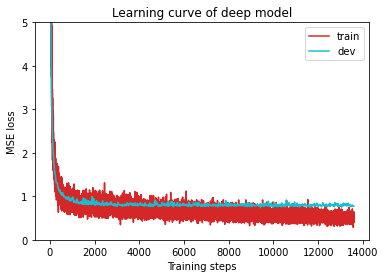

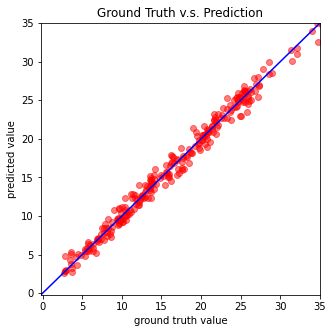

Saving results to mypred.csv
All Done!


In [16]:
# 设置存储模型的目录
os.makedirs('my_models', exist_ok=True)

# 加载数据
train_data = prep_dataloader('./covid.train.csv', 'train', batch_size=135)
dev_data = prep_dataloader('./covid.train.csv', 'dev', batch_size=135)
test_data = prep_dataloader('./covid.test.csv', 'test', batch_size=135)
 
# 设置模型与训练
mymodel = Mymodel(train_data.dataset.dim)
train_loss, dev_loss = train(mymodel, train_data, dev_data)
plot_learning_curve(train_loss, dev_loss, title='deep model')  #绘制loss函数
del mymodel
 
# 加载最好的模型进行预测
model = Mymodel(train_data.dataset.dim)
ckpt = torch.load('my_models/mymodel.pth', map_location='cpu')  # 加载最好的模型 之前已经根据验证集弄出了dev_loss最小的模型
model.load_state_dict(ckpt)
plot_pred(dev_data, model, 'cpu')   #绘制最好的模型  在验证集上的表现 和真实值的差别

preds = test(model, test_data)
 
# 储存预测结果
save_pred(preds, 'mypred.csv')
print('All Done!')

# **全代码**   只要运行这个就行

train data done!
dev data done!
test data done!
Saving model (epoch =    2, loss = 51.0681)
Saving model (epoch =    3, loss = 12.6505)
Saving model (epoch =    4, loss = 5.6752)
Saving model (epoch =    5, loss = 4.0360)
Saving model (epoch =    6, loss = 3.3920)
Saving model (epoch =    7, loss = 2.8617)
Saving model (epoch =    8, loss = 2.4789)
Saving model (epoch =    9, loss = 2.2375)
Saving model (epoch =   10, loss = 2.0216)
Saving model (epoch =   11, loss = 1.8489)
Saving model (epoch =   12, loss = 1.7353)
Saving model (epoch =   13, loss = 1.5770)
Saving model (epoch =   14, loss = 1.5064)
Saving model (epoch =   15, loss = 1.4060)
Saving model (epoch =   16, loss = 1.3681)
Saving model (epoch =   17, loss = 1.3126)
Saving model (epoch =   18, loss = 1.2665)
Saving model (epoch =   19, loss = 1.2314)
Saving model (epoch =   20, loss = 1.1806)
Saving model (epoch =   22, loss = 1.1721)
Saving model (epoch =   26, loss = 1.1052)
Saving model (epoch =   27, loss = 1.0713)
Savi

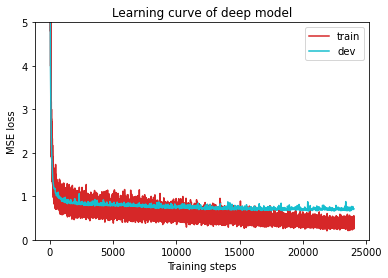

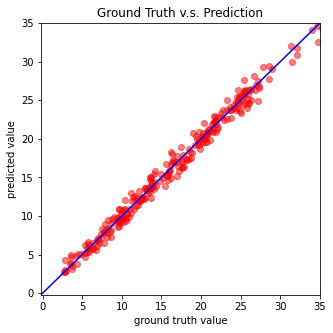

Saving results to mypred.csv
All Done!


In [15]:
import torch
from torch import nn,optim
from torch.utils.data import DataLoader,Dataset
 
import csv
import numpy as np
import os
import matplotlib.pyplot as plt
 
myseed = 42069  # 作用是为了其他人复现的时候更接近作者的结果
np.random.seed(myseed)
torch.manual_seed(myseed)
 
 
# 数据类的处理
class Covid19dataset(Dataset):
    def __init__(self, path, mode='train'):
        super().__init__()
        self.mode = mode
 
        # 读取数据
        with open(path) as file:
            data_csv = list(csv.reader(file))   # 将csv文件中获取的数据转换为列表类型
            data = np.array(data_csv[1:])[:, 1:].astype(float)  # 获取文件中的【数值数据】
 
        if mode == 'test':  # 由于训练集、验证集与测试集的数据有所不同（最后一列数据），在此分情况运行
            data = data[:, 0:93]    # 测试集中，由于最后一行是得预测的数据，故只有93列
            self.data = torch.FloatTensor(data)     # 将numpy类型数据转换为tensor类型
        else:
            target = data[:, -1]    # 训练集和验证集中用于对比结果的“目标”
            data = data[:, 0:93]
            train_index = []
            dev_index = []
            for i in range(data.shape[0]):     # 这个循环用于将covid.train.csv文件中的数据分为训练集和验证集
                if i % 10 != 0:                # 取序号为整十数的样本作为验证集
                    train_index.append(i)
                else:
                    dev_index.append(i)
            if mode == 'train':     # 训练集的数据
                self.target = torch.FloatTensor(target[train_index])
                self.data = torch.FloatTensor(data[train_index, 0:93])
            else:       # 测试集的数据
                self.target = torch.FloatTensor(target[dev_index])
                self.data = torch.FloatTensor(data[dev_index, 0:93])
 
        # 此处是对数据进行标准化处理，可以将不同量纲的不同特征，变为同一个数量级，使得损失函数更加平滑
        # 标准化的优点：①提升模型的精度   ②提升收敛速度
        # 采用均值标准化： （第i维数据 - 第i维数据的平均值）/（第i维数据的标准差）
        self.data[:, 40:] = (self.data[:, 40:] - self.data[:, 40:].mean(dim=0)) / self.data[:, 40:].std(dim=0)
 
        self.dim = self.data.shape[1]   # 获取数据的列数
 
    def __getitem__(self, item):        # 【注】这是Dataset必须重写的类函数，意在按索引返回数据
        if self.mode == 'train' or self.mode == 'dev':  # 训练集和验证集包含特征和目标数据
            return self.data[item], self.target[item]
        else:
            return self.data[item]      # 测试集仅含有特征数据
 
    def __len__(self):                  # 【注】返回数据的行数
        return len(self.data)
 
 
def prep_dataloader(path, mode, batch_size, n_jobs=0):
    dataset = Covid19dataset(path, mode)    # 定义一个Dataset类
    dataloader = DataLoader(dataset, batch_size,
                            shuffle=(mode == 'train'),  # 【是否打乱数据后再读取】
                            drop_last=False,            # 【False表示不丢弃不能被batch_size整除的部分】
                            num_workers=n_jobs,         # 【采用多少个进程读取数据】
                            pin_memory=False)           # 【是否将数据载入CUDA的内存当中】
    print(mode, 'data done!')
    return dataloader
 
 
# 这部分可以直接到pytorch的官方文档中查看对应类或函数的使用方法
class Mymodel(nn.Module):
    def __init__(self, input_dim):
        super(Mymodel, self).__init__()
        self.net = nn.Sequential(           # 设置好模型的结构，可在forward函数中直接按顺序运行
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )
 
        self.criterion = nn.MSELoss(reduction='mean')   # 计算Loss
 
    def forward(self, x):
        return self.net(x).squeeze(1)       # 对数据的维度进行压缩，方便预测值与实际值的对比
 
    def cal_loss(self, pred, target):
        return self.criterion(pred, target)     # 计算Loss
 
 
def train(model, train_data, dev_data):
    max_epoch = 3000    # 至多训练次数
    epoch = 1
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)   # 初始化梯度下降法
    train_loss = []     # 存储训练集的Loss
    dev_loss = []       # 存储测试集的Loss
    min_mse = 1000
    break_flag = 0
    while epoch < max_epoch:
        model.train()               # 设置模式
        for x, y in train_data:     # x，y 每次包含一个batch_size的样本
            optimizer.zero_grad()   # 每次必须先将梯度清零
            pred = model(x)
            loss = model.cal_loss(pred, y)  # 计算Loss
            train_loss.append(loss.detach())
            loss.backward()         # 计算梯度
            optimizer.step()        # 模型的参数更新
 
        dev_mse = dev(model, dev_data)
        if dev_mse < min_mse:       # 如果测试验证集的Loss比上一次小，则存储当前模型
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                  .format(epoch + 1, min_mse))
 
            # 存储当前最好的模型，此处需要导入os库，创建相应的目录
            torch.save(model.state_dict(), 'my_models/mymodel.pth')
 
            break_flag = 0
        else:
            break_flag += 1
 
        dev_loss.append(dev_mse.detach())
 
        if break_flag > 200:    # 如果连续200个周期，Loss都没有下降，则结束训练
            break
 
        epoch += 1
    return train_loss, dev_loss
 
 
def dev(model, dev_data):
    model.eval()            # 设置模式
    total_loss = []
 
    for x, y in dev_data:       # 得到当前模型下验证集的Loss
        pred = model(x)
        dev_loss = model.cal_loss(pred, y)
        total_loss.append(dev_loss)
 
    return sum(total_loss) / len(total_loss)    # 取Loss的平均数
 
 
def test(model, test_data):
    model.eval()            # 设置模式
    preds = []
    for x in test_data:     # 计算获得【预测值】
        pred = model(x)
        preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()
    return preds
 
 
def plot_learning_curve(train_loss, dev_loss, title=''):
    total_steps = len(train_loss)
    x_1 = range(total_steps)
    x_2 = x_1[::len(train_loss) // len(dev_loss)]
    plt.figure(1, figsize=(6, 4))
    plt.plot(x_1, train_loss, c='tab:red', label='train')
    plt.plot(x_2, dev_loss, c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)       
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()      
    plt.show()
 
 
def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()
    plt.figure(2, figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()
 
 
def save_pred(preds, file):
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):   # enumerate() 函数用于将一个可遍历的数据对象组合为一个索引序列，同时列出数据和数据下标
            writer.writerow([i, p])
 
# 设置存储模型的目录
os.makedirs('my_models', exist_ok=True)
 
# 加载数据
train_data = prep_dataloader('covid.train.csv', 'train', batch_size=135)
dev_data = prep_dataloader('covid.train.csv', 'dev', batch_size=135)
test_data = prep_dataloader('covid.test.csv', 'test', batch_size=135)
 
# 设置模型与训练
mymodel = Mymodel(train_data.dataset.dim)
train_loss, dev_loss = train(mymodel, train_data, dev_data)
plot_learning_curve(train_loss, dev_loss, title='deep model')
del mymodel
 
# 加载最好的模型进行预测
model = Mymodel(train_data.dataset.dim)
ckpt = torch.load('my_models/mymodel.pth', map_location='cpu')  # 加载最好的模型
model.load_state_dict(ckpt)
plot_pred(dev_data, model, 'cpu')
preds = test(model, test_data)
 
# 储存预测结果
save_pred(preds, 'mypred.csv')
print('All Done!')